## Loss

In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
from tensorboard_extract import convert_tfevent
import os 
import pandas as pd 
import seaborn as sns 
import matplotlib.cm as cm 
import pickle 
from scipy.stats import skew


if not os.path.exists("results"):
    os.makedirs("results")

dfs = [] 
for training in os.listdir('../results'):
    config_path = f'../results/{training}'
    event_path =os.path.join(config_path, [f for f in os.listdir(config_path) if 'events.' in f][-1])
    df = convert_tfevent(event_path)
    df = df[df['name'] == 'loss']   
    df['type'] = training
    dfs.append(df)

loss_df = pd.concat(dfs).reset_index()
loss_df.head()

,index,wall_time,name,step,value,type
0,0,1.670202e+09,loss,0,1.677111,orthogonal
1,1,1.670202e+09,loss,1,1.372931,orthogonal
2,2,1.670202e+09,loss,2,1.254562,orthogonal
3,3,1.670202e+09,loss,3,1.176669,orthogonal
4,4,1.670202e+09,loss,4,1.118855,orthogonal


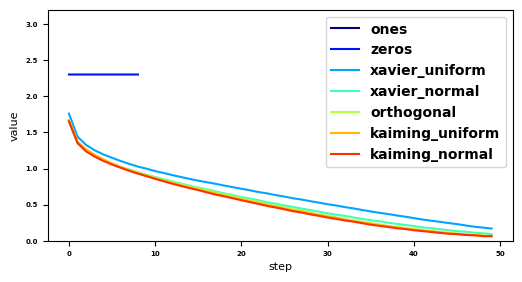

In [9]:
cmap = cm.get_cmap("jet")
plt.figure(figsize=(6,3))
sns.lineplot(x='step', y='value', data=loss_df, hue='type', 
             hue_order=['ones', 'zeros','xavier_uniform', 'xavier_normal', 'orthogonal', 'kaiming_uniform', 'kaiming_normal'],
             palette=[cmap(i/7) for i in range(7)])
plt.ylim(0, 3.2)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("results/loss.pdf")

# Visualize the Feature distribution 

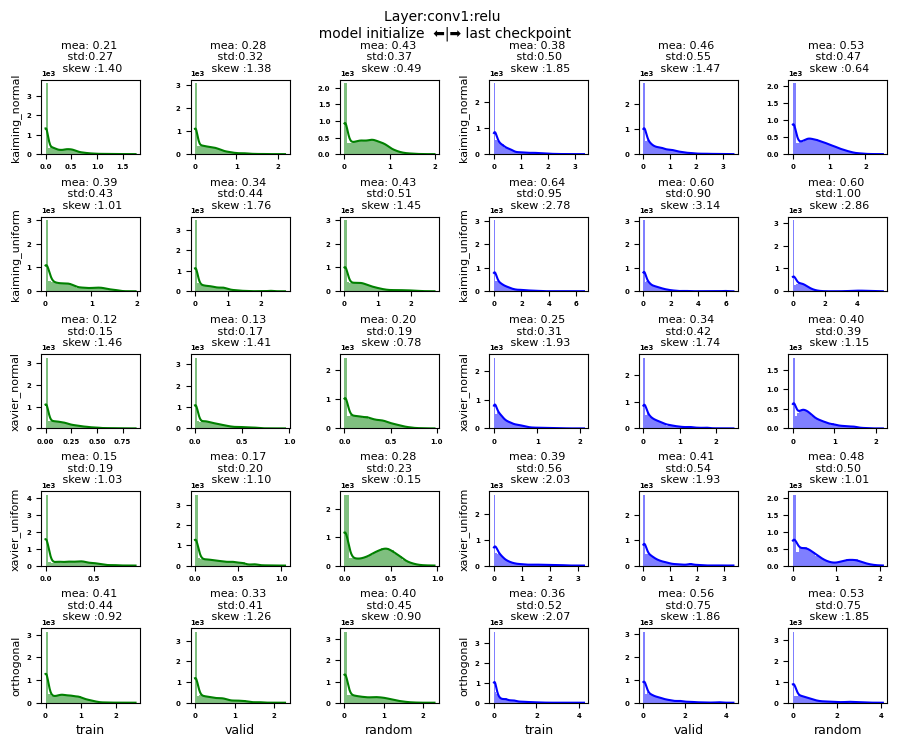

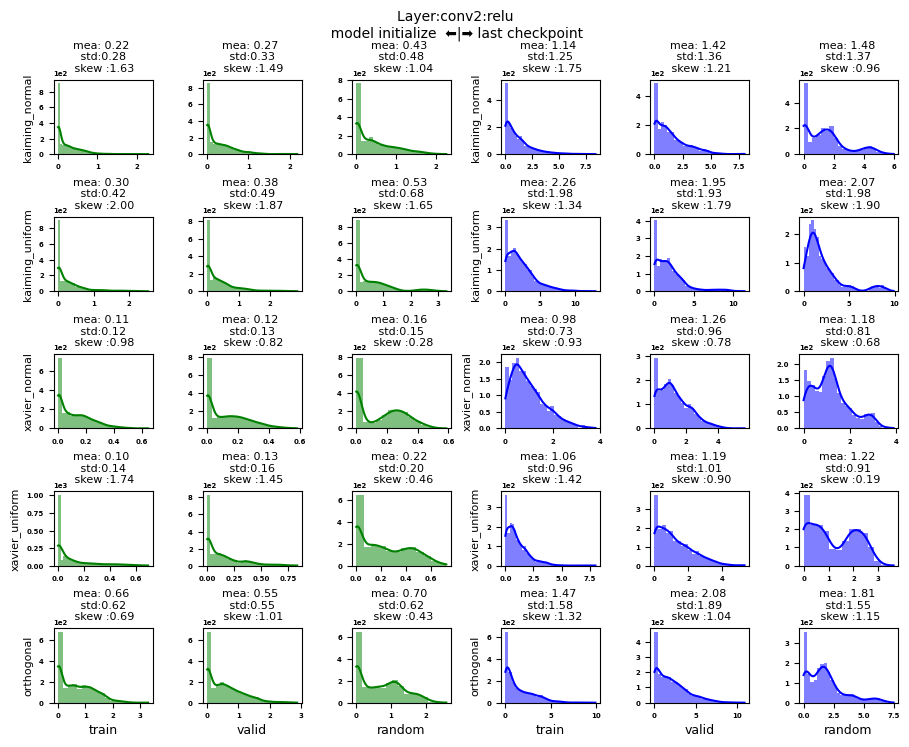

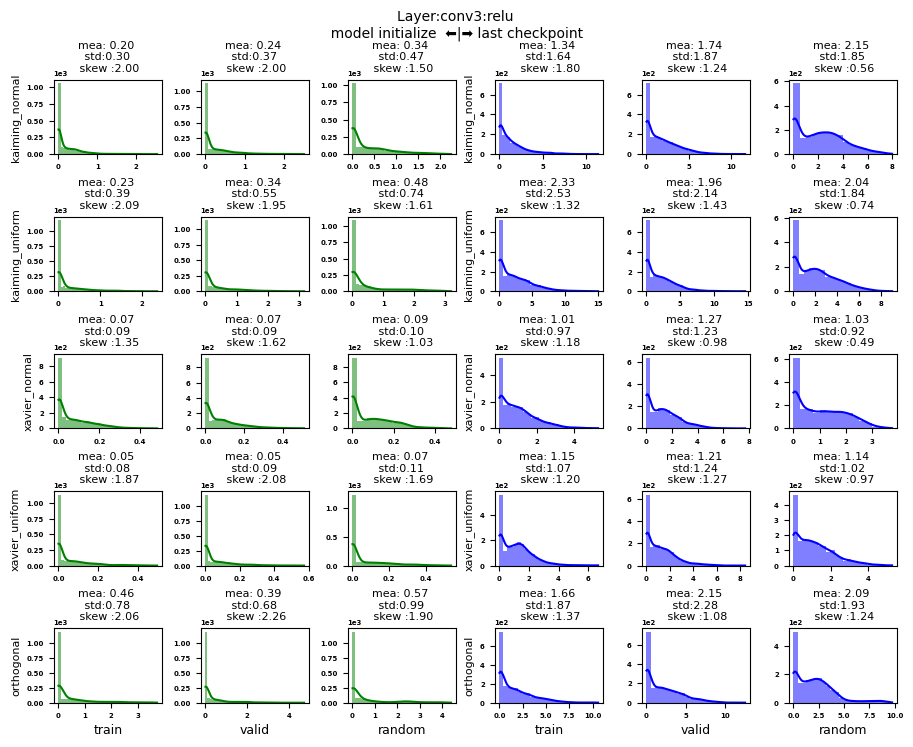

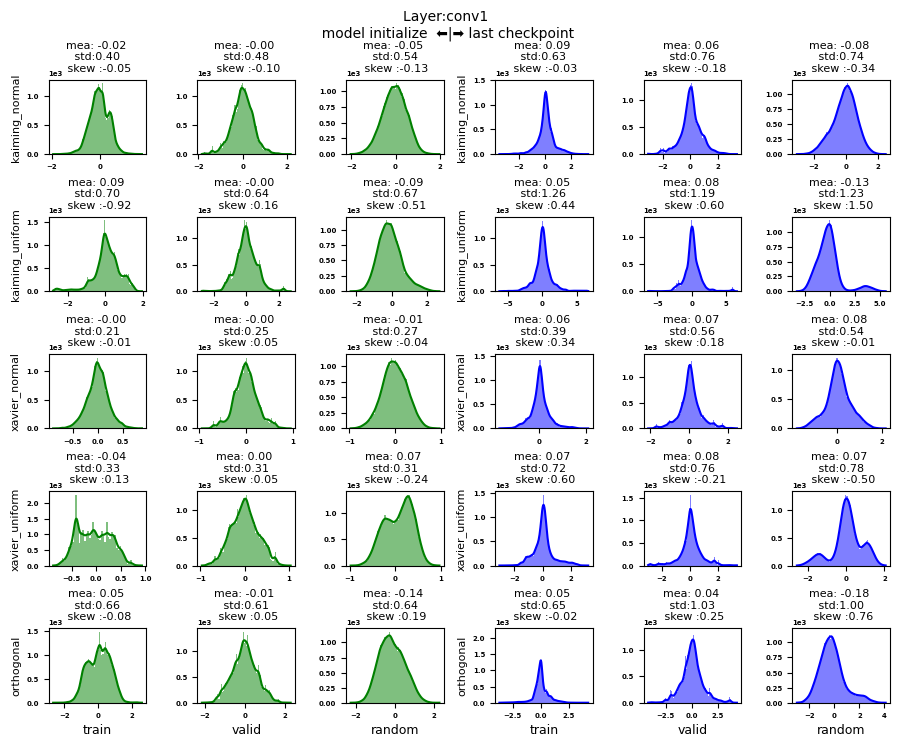

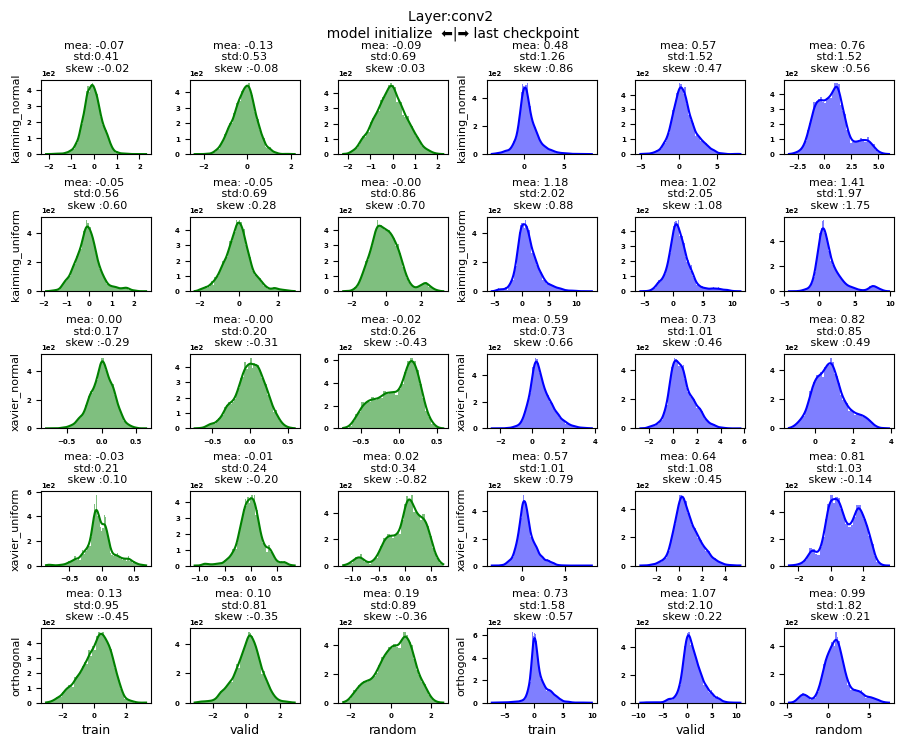

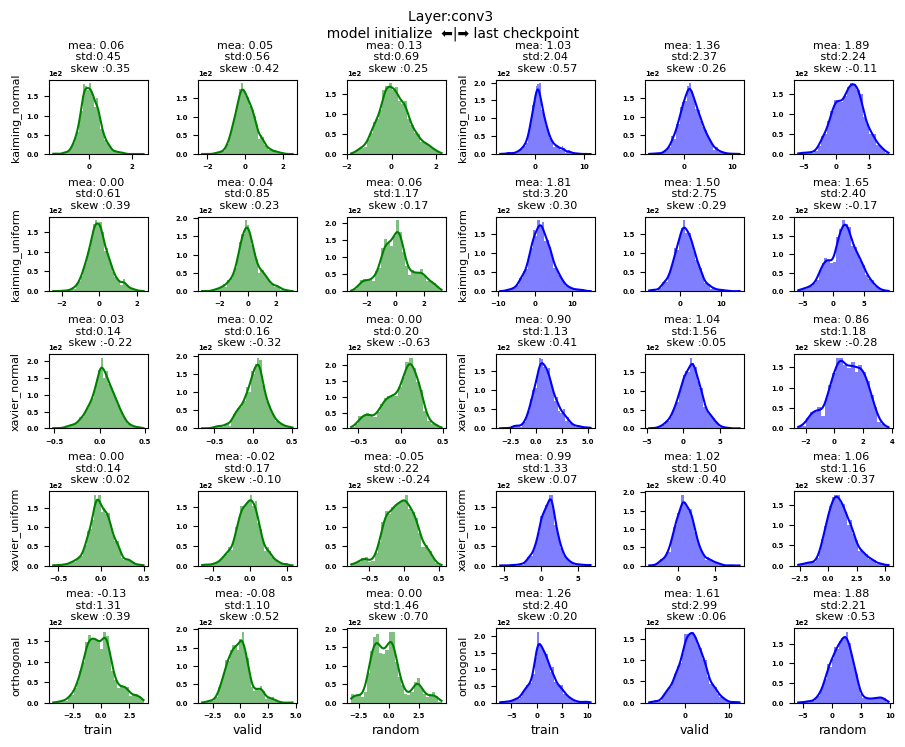

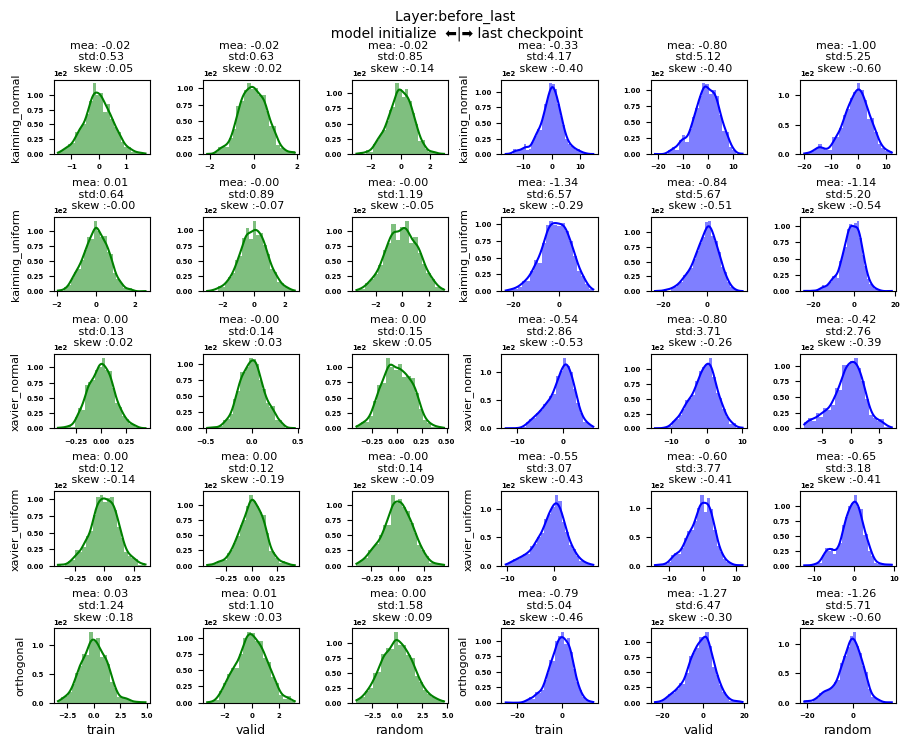

In [7]:


names = ['kaiming_normal', 'kaiming_uniform', 'xavier_normal', 'xavier_uniform', 'orthogonal']
pkls = ['train', 'valid', 'random']
epochs = ['init', 'last']

features = {name:{epoch:{pkl:{} for pkl in pkls } for epoch in epochs} for name in names}
layer_names = ['conv1:relu', 'conv2:relu','conv3:relu','conv1','conv2', 'conv3', 'before_last']
# for visualization efficiency
max_samples = 2

plt.rcParams['font.size'] = 5
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 8

for i in range(7):
    fig, axes = plt.subplots(len(names), len(pkls)*2, figsize=(len(pkls)*3, len(names)*1.5))
    
    for e_i, epoch in enumerate(epochs):    
        for y_i, name in enumerate(names):
            for x_i, pkl in enumerate(pkls):
                path = f'../results/{name}/{epoch}_{pkl}.pkl'
                feature = pickle.load(open(path, 'rb'))
                feature = feature[i] # select the list 
                feature = feature[:max_samples, ...]
                ax = axes[y_i, x_i + len(pkls)*(e_i)]
            
                cmap = cm.get_cmap('jet')
                try:
                    sns.histplot(data=feature.reshape(-1), lw=0.0, kde=True, ax=ax, color=['green', 'blue'][e_i])
                except:
                    sns.histplot(data=feature.reshape(-1), lw=0.0, ax=ax, color=['green', 'blue'][e_i])
                # ax.get_legend().remove()
                
                if x_i==0:
                    ax.set_ylabel(name, rotation=90, fontsize=8)
                else:
                    ax.set_ylabel(None)
                if y_i==0:
                    ax.set_title(pkl, fontsize=8)
                else:
                    ax.set_xlabel(None)
                if y_i == len(names) -1:
                    ax.set_xlabel(pkl, fontsize=9)
                ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  
                ax.set_title(f"mea: {np.mean(feature.reshape(-1)):.2f} \n std:{np.std(feature.reshape(-1)):.2f} \n skew :{skew(feature.reshape(-1)):.2f}", fontsize=8)
    
        # fig.supylabel(names)
        # fig.supxlabel(pkls)
    fig.suptitle(f'Layer:{layer_names[i]} \n  model initialize  ⬅|➡ last checkpoint  ', fontsize=10)
    fig.tight_layout()
    plt.savefig(f"results/dist_{i}.pdf")

# Weight Distribution 

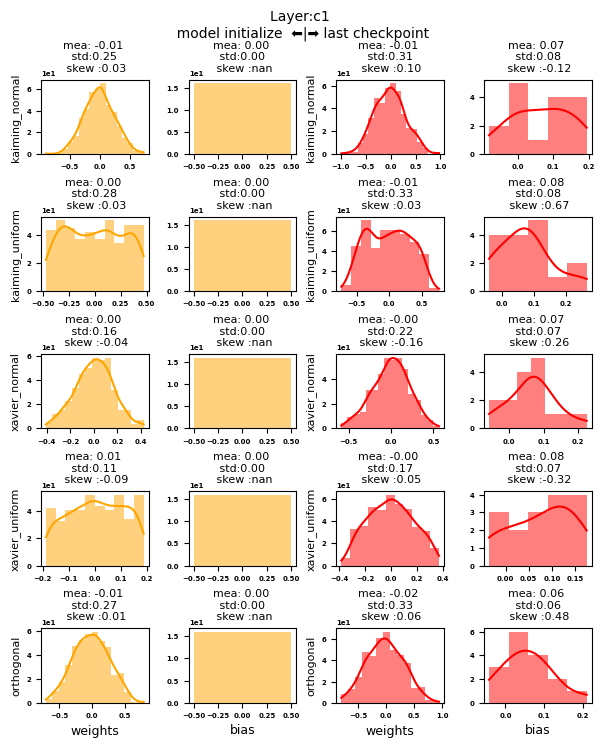

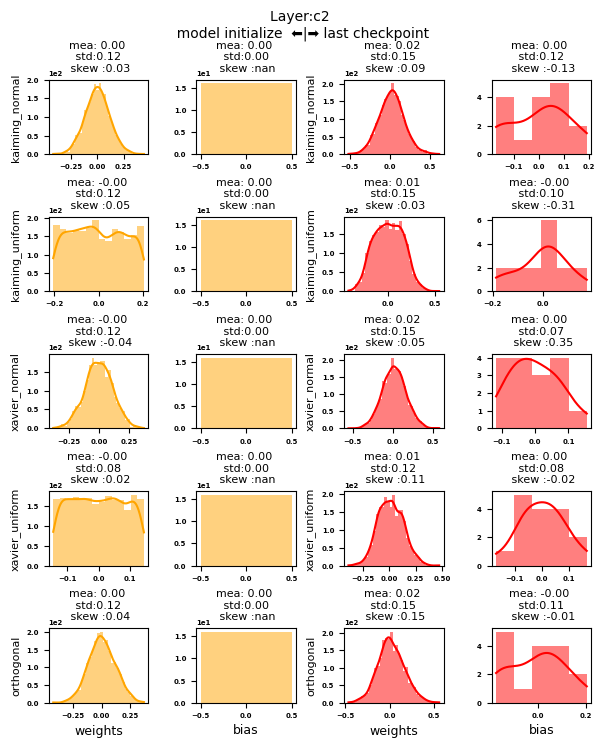

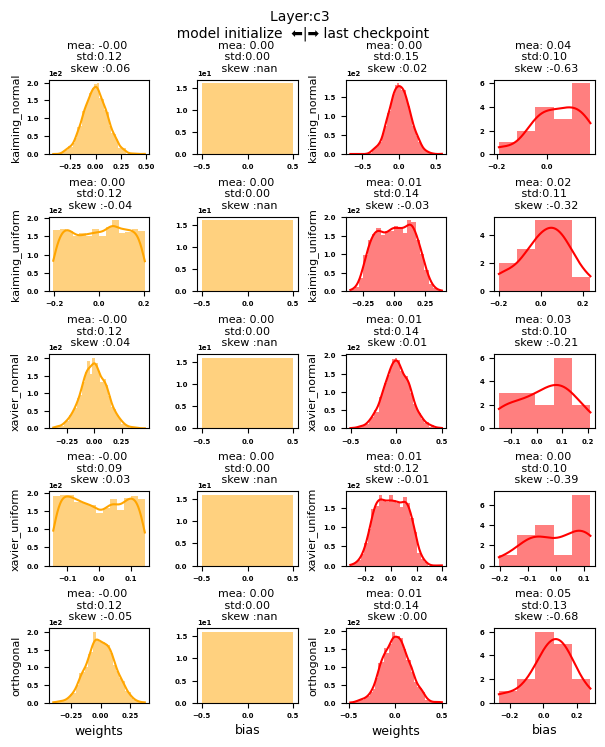

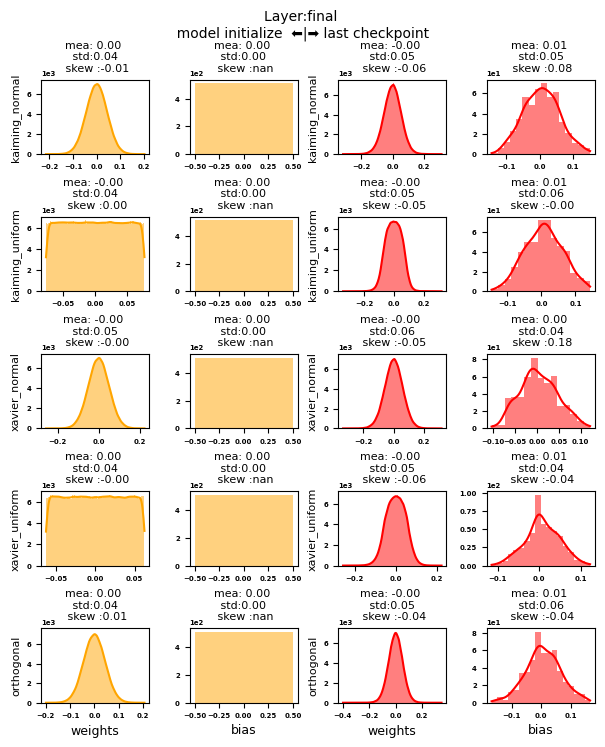

In [6]:
import torch 
import sys 
sys.path.append("../")
from src.model import Model 
from scipy.stats import skew


plt.rcParams['font.size'] = 5
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 8


names = ['kaiming_normal', 'kaiming_uniform', 'xavier_normal', 'xavier_uniform', 'orthogonal']
epochs = ['init', 'last']
pkls = ['weights', 'bias']
feature_names = ['c1', 'c2' ,'c3', 'final']

for i in range(4):
    fig, axes = plt.subplots(len(names), len(pkls)*2, figsize=(len(pkls)*3, len(names)*1.5))
    for e_i, epoch in enumerate(epochs):    
        for y_i, name in enumerate(names):
            for x_i, pkl in enumerate(pkls):
                path = f'../results/{name}/model_{epoch}.pt'
                model = Model(lambda x:x)
                model.load_state_dict(torch.load(f'../results/{name}/model_{epoch}.pt'))
                in_layer_index = 0 if i<3 else 1
                feature =[getattr(model , feature_names[i])[in_layer_index].weight.cpu().detach().numpy(), getattr(model , 
                                                            feature_names[i])[in_layer_index].bias.cpu().detach().numpy()][x_i]
                ax = axes[y_i, x_i + len(pkls)*(e_i)]
            
                cmap = cm.get_cmap('jet')
                try:
                    sns.histplot(data=feature.reshape(-1), lw=0.0, stat='count', kde=True, ax=ax, color=['orange', 'red'][e_i])
                except:
                    sns.histplot(data=feature.reshape(-1), lw=0.0, stat='count', ax=ax, color=['orange', 'red'][e_i])
                # ax.get_legend().remove()
                
                if x_i==0:
                    ax.set_ylabel(name, rotation=90, fontsize=8)
                else:
                    ax.set_ylabel(None)
                if y_i==0:
                    ax.set_title(pkl, fontsize=8)
                else:
                    ax.set_xlabel(None)
                if y_i == len(names) -1:
                    ax.set_xlabel(pkl, fontsize=9)
                ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0),)
                # ax.set_yticks(ax.get_yticks(),fontsize=5)  
                # ax.set_xticks(ax.get_xticks(), fontsize=5)  
                ax.set_title(f"mea: {np.mean(feature.reshape(-1)):.2f} \n std:{np.std(feature.reshape(-1)):.2f} \n skew :{skew(feature.reshape(-1)):.2f}", fontsize=8)
        
            # fig.supylabel(names)
            # fig.supxlabel(pkls)
    fig.suptitle(f'Layer:{feature_names[i]} \n  model initialize  ⬅|➡ last checkpoint  ', fontsize=10)
    fig.tight_layout()
    plt.savefig(f"results/weight_{i}.pdf")

# Compute the distribtuion measure 

In [3]:
# layer similarity with init and the trained features 
from scipy.special import kl_div

def compute_similarity(A, B, method=None):
    if method =='kl_div':
        return kl_div(A, B)
    else:
        assert ValueError()
        
from tqdm import tqdm 

names = ['kaiming_normal', 'kaiming_uniform', 'xavier_normal', 'xavier_uniform', 'orthogonal']
pkls = ['train', 'valid', 'random']


result_dict = {
    'method' : [],
    'layer' : [],
    'init' : [],
    'input' : [],
    'sim' : [] 
}

for name in tqdm(names):
    for pkl in pkls:
        pathA = f'../results/{name}/last_{pkl}.pkl'
        featuresA = pickle.load(open(pathA, 'rb'))[i]
        pathB = f'../results/{name}/init_{pkl}.pkl'
        featuresB = pickle.load(open(pathB, 'rb'))[i]
        for method in (['kl']):
            for i in range(3):  # layers : only convolutions
                featureA = featuresA[i] # select the list 
                A = featureA.flatten()
                featureB = featuresB[i] # select the list 
                B = featureB.flatten()
                sim = compute_similarity(A,B)
                result_dict['method'].append(method)
                result_dict['layer'].append(i)
                result_dict['init'].append(name)
                result_dict['input'].append(pkl)
                result_dict['sim'].append(sim)
df = pd.DataFrame(result_dict)         
df.head()       

  0%|          | 0/5 [00:00<?, ?it/s]


NameError: name 'pickle' is not defined

In [ ]:
plt.rcParams['font.size'] = 13

for input in ['train', 'valid', 'random']:
    # plt.figure(figsize=(6,4))
    df_temp = df[df['input']==input]
    rel = sns.relplot(y='sim', x='layer', hue='init', col='method', data=df_temp, kind='line', lw=2, 
                hue_order=['xavier_uniform', 'xavier_normal', 'orthogonal', 'kaiming_uniform', 'kaiming_normal'],
                palette=[cmap(i/5) for i in range(5)])
    rel.fig.subplots_adjust(top=.8, right=1.0)
    rel.fig.suptitle(input, fontsize=25)
    rel.legend.set_bbox_to_anchor((1.2,0.5))
    plt.xticks([0,1,2])
    fig.tight_layout()